# Hash functions and multiplanes

A key point for the lookup using hash functions is the calculation of the hash key or bucket id that we assign for a given entry. In this notebook, we will cover:

* Basic hash tables
* Multiplanes
* Random planes

## Basic Hash tables

Hash tables are data structures that allow indexing data to make lookup tasks more efficient. 
In this part, you will see the implementation of the simplest hash function.

In [1]:
import numpy as np                # library for array and matrix manipulation
import pprint                     # utilities for console printing 
from utils_nb import plot_vectors # helper function to plot vectors
import matplotlib.pyplot as plt   # visualization library

pp = pprint.PrettyPrinter(indent=4) # Instantiate a pretty printer

A straightforward hash function for integer numbers. The function will receive a list of integer numbers and the desired amount of buckets. The function will produce a hash table stored as a dictionary, where keys contain the hash keys, and the values will provide the hashed elements of the input list. 

The hash function is just the remainder of the integer division between each element and the desired number of buckets.

In [2]:
def basic_hash_table(value_l, n_buckets):
    
    def hash_function(value, n_buckets):
        return int(value) % n_buckets
    
    hash_table = {i:[] for i in range(n_buckets)} # Initialize all the buckets in the hash table as empty lists

    for value in value_l:
        hash_value = hash_function(value,n_buckets) # Get the hash key for the given value
        hash_table[hash_value].append(value) # Add the element to the corresponding bucket
    
    return hash_table

Now let's see the hash table function in action. The pretty print function (`pprint()`) will produce a visually appealing output. 

In [3]:
value_l = [100, 10, 14, 17, 97] # Set of values to hash
hash_table_example = basic_hash_table(value_l, n_buckets=10)
pp.pprint(hash_table_example)

{   0: [100, 10],
    1: [],
    2: [],
    3: [],
    4: [14],
    5: [],
    6: [],
    7: [17, 97],
    8: [],
    9: []}


In this case, the bucket key must be the rightmost digit of each number.

## Planes

Multiplanes hash functions are other types of hash functions. Multiplanes hash functions are based on the idea of numbering every single region that is formed by the intersection of n planes. In the following code, we show the most basic forms of the multiplanes principle. First, with a single plane:

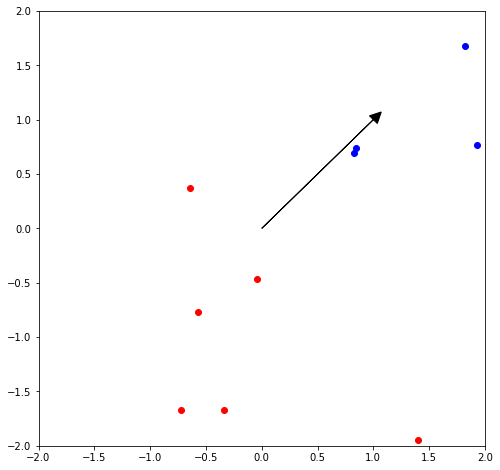

In [4]:
P = np.array([[1, 1]]) # Define a single plane. 
fig, ax1 = plt.subplots(figsize=(8, 8)) # Create a plot

plot_vectors([P], axes=[2, 2], ax=ax1) # Plot the plane P as a vector

# Plot  random points. 
for i in range(0, 10):
        v1 = np.array(np.random.uniform(-2, 2, 2)) # Get a pair of random numbers between -4 and 4 
        side_of_plane = np.sign(np.dot(P, v1.T)) 
        
        # Color the points depending on the sign of the result of np.dot(P, point.T)
        if side_of_plane == 1:
            ax1.plot([v1[0]], [v1[1]], 'bo') # Plot blue points
        else:
            ax1.plot([v1[0]], [v1[1]], 'ro') # Plot red points

plt.show()


The first thing to note is that the vector that defines the plane does not mark the boundary between the two sides of the plane. It marks the direction in which you find the 'positive' side of the plane. Not intuitive at all!

If we want to plot the separation plane, we need to plot a line that is perpendicular to our vector `P`. We can get such a line using a $90^o$ rotation matrix.

Feel free to change the direction of the plane `P`.

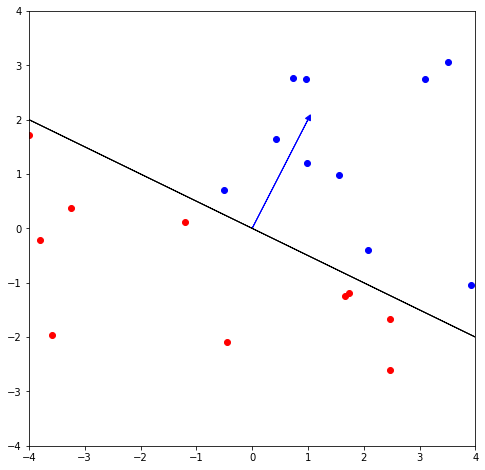

In [5]:
P = np.array([[1, 2]])  # Define a single plane. You may change the direction

# Get a new plane perpendicular to P. We use a rotation matrix
PT = np.dot([[0, 1], [-1, 0]], P.T).T  

fig, ax1 = plt.subplots(figsize=(8, 8)) # Create a plot with custom size

plot_vectors([P], colors=['b'], axes=[2, 2], ax=ax1) # Plot the plane P as a vector

# Plot the plane P as a 2 vectors. 
# We scale by 2 just to get the arrows outside the current box
plot_vectors([PT * 4, PT * -4], colors=['k', 'k'], axes=[4, 4], ax=ax1)

# Plot 20 random points. 
for i in range(0, 20):
        v1 = np.array(np.random.uniform(-4, 4, 2)) # Get a pair of random numbers between -4 and 4 
        side_of_plane = np.sign(np.dot(P, v1.T)) # Get the sign of the dot product with P
        # Color the points depending on the sign of the result of np.dot(P, point.T)
        if side_of_plane == 1:
            ax1.plot([v1[0]], [v1[1]], 'bo') # Plot a blue point
        else:
            ax1.plot([v1[0]], [v1[1]], 'ro') # Plot a red point

plt.show()


Now, let us see what is inside the code that color the points. 

In [6]:
P = np.array([[1, 1]])      # Single plane
v1 = np.array([[1, 2]])     # Sample point 1
v2 = np.array([[-1, 1]])    # Sample point 2
v3 = np.array([[-2, -1]])   # Sample point 3

In [7]:
np.dot(P, v1.T)

array([[3]])

In [8]:
np.dot(P, v2.T)

array([[0]])

In [9]:
np.dot(P, v3.T)

array([[-3]])

The function below checks in which side of the plane P is located the vector `v`

In [10]:
def side_of_plane(P, v):
    dotproduct = np.dot(P, v.T) # Get the dot product P * v'
    sign_of_dot_product = np.sign(dotproduct) # The sign of the elements of the dotproduct matrix 
    sign_of_dot_product_scalar = sign_of_dot_product.item() # The value of the first item
    return sign_of_dot_product_scalar

In [11]:
side_of_plane(P, v1) # In which side is [1, 2]

1

In [12]:
side_of_plane(P, v2) # In which side is [-1, 1]

0

In [13]:
side_of_plane(P, v3) # In which side is [-2, -1]

-1

## Hash Function with multiple planes

In the following section, we are going to define a hash function with a list of three custom planes in 2D.

In [14]:
P1 = np.array([[1, 1]])   # First plane 2D
P2 = np.array([[-1, 1]])  # Second plane 2D
P3 = np.array([[-1, -1]]) # Third plane 2D
P_l = [P1, P2, P3]  # List of arrays. It is the multi plane

# Vector to search
v = np.array([[2, 2]])

The next function creates a hash value based on a set of planes. The output value is a combination of the side of the plane where the vector is localized with respect to the collection of planes.

We can think of this list of planes as a set of basic hash functions, each of which can produce only 1 or 0 as output.

In [15]:
def hash_multi_plane(P_l, v):
    hash_value = 0
    for i, P in enumerate(P_l):
        sign = side_of_plane(P,v)
        hash_i = 1 if sign >=0 else 0
        hash_value += 2**i * hash_i
    return hash_value

In [16]:
hash_multi_plane(P_l, v) # Find the number of the plane that containes this value

3

## Random Planes

In the cell below, we create a set of three random planes

In [17]:
np.random.seed(0)
num_dimensions = 2 # is 300 in assignment
num_planes = 3 # is 10 in assignment
random_planes_matrix = np.random.normal(size=(num_planes, num_dimensions))
print(random_planes_matrix)

[[ 1.76405235  0.40015721]
 [ 0.97873798  2.2408932 ]
 [ 1.86755799 -0.97727788]]


In [18]:
v = np.array([[2, 2]])

The next function is similar to the `side_of_plane()` function, but it evaluates more than a plane each time. The result is an array with the side of the plane of `v`, for the set of planes `P`

In [19]:
# Side of the plane function. The result is a matrix
def side_of_plane_matrix(P, v):
    dotproduct = np.dot(P, v.T)
    sign_of_dot_product = np.sign(dotproduct) # Get a boolean value telling if the value in the cell is positive or negative
    return sign_of_dot_product

Get the side of the plane of the vector `[2, 2]` for the set of random planes. 

In [20]:
sides_l = side_of_plane_matrix(random_planes_matrix, v)
sides_l

array([[1.],
       [1.],
       [1.]])

Now, let us use the former function to define our multiplane hash function

In [ ]:
def hash_multi_plane_matrix(P, v, num_planes):
    sides_matrix = side_of_plane_matrix(P, v) # Get the side of planes for P and v
    hash_value = 0
    for i in range(num_planes):
        sign = sides_matrix[i].item() # Get the value inside the matrix cell
        hash_i = 1 if sign >=0 else 0
        hash_value += 2**i * hash_i # sum 2^i * hash_i
        
    return hash_value

Print the bucket hash for the vector `v = [2, 2]`. 

In [ ]:
hash_multi_plane_matrix(random_planes_matrix, v, num_planes)

#### Note
This showed you how to make one set of random planes.  You will make multiple sets of random planes in order to make the approximate nearest neighbors more accurate.

## Document vectors

Before we finish this lab, remember that you can represent a document as a vector by adding up the word vectors for the words inside the document. In this example, our embedding contains only three words, each represented by a 3D array.

In [ ]:
word_embedding = {"I": np.array([1,0,1]),
                   "love": np.array([-1,0,1]),
                   "learning": np.array([1,0,1])
                  }
words_in_document = ['I', 'love', 'learning', 'not_a_word']
document_embedding = np.array([0,0,0])
for word in words_in_document:
    document_embedding += word_embedding.get(word,0)
    
print(document_embedding)

**Congratulations! You've now completed this lab on hash functions and multiplanes!**